# Dataset

We will use the MIH-BIH Arrythmia dataset from https://physionet.org/content/mitdb/1.0.0/. This is a dataset with 48 half-hour two-channel ECG recordings measured at 360 Hz. The recordings have annotations from cardiologists for each heart beat. The symbols for the annotations can be found at https://archive.physionet.org/physiobank/annotations.shtml

# Project Definition

Predict if a heart beat from the first ECG signal has an arrhythmia for each 6 second window centered on the peak of the heart beat. To simplify the problem, we will assume that a QRS detector is capable of automatically identifying the peak of each heart beat. We will ignore any non-beat annotations and any heart beats in the first or last 3 seconds of the recording due to reduced data. We will use a window of 6 seconds so we can compare the current beat to beats just before and after. This decision was based after talking to a physician who said it is easier to identify if you have something to compare it to.

# Data Preparation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir


In [ ]:
# data must be downloaded and path provided
data_path = r'/content/drive/MyDrive/deep_arrhythmias-master/mit-bih-arrhythmia-database-1.0.0/'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

Here we will use a pypi package wfdb for loading the ecg and annotations.  

In [ ]:
pip install wfdb

     |████████████████████████████████| 133kB 8.7MB/s 


Let's load all the annotations and see the distribution of heart beat types across all files.

In [ ]:
import wfdb
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [ ]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [ ]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [ ]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [ ]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

function for loading a single patient's signals and annotations. Note the annotation values are the indices of the signal array.

In [ ]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

checking for what abnormal beats are in a patient's ecg:

In [ ]:
file = data_path + pts[0]

In [ ]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [ ]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


Let's make a plot of these, zooming in on one of the abnormal beats

In [ ]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [ ]:
x = np.arange(len(p_signal))

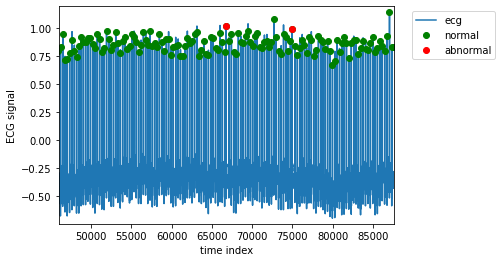

In [ ]:
left = ab_index[1]-20800
right = ab_index[1]+20800

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

# Make a dataset
Let's make a dataset that is centered on beats with +- 3 seconds before and after. 

In [ ]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym
    

# Split on patients not on samples
 start by processing all of our patients.

In [ ]:
num_sec = 3
fs = 360

In [ ]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)

In [ ]:
##Feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.5MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

Lest create a model which shows how may hyperparameters that can be used in this model. For the better evaluation purpose

In [62]:
## Perform Hyperparameter Optimization

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid



def create_model(layers, activation):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=X_train.shape[1]))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
        else:
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(0.3))
            
    model.add(Dense(units = 1, kernel_initializer= 'glorot_uniform', activation = 'sigmoid')) # Note: no activation beyond this point
    
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
X_train.shape[1]

2160

In [63]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [ ]:
layers = [[20], [40, 20]]
activations = ['sigmoid', 'relu']
param_grid = dict(layers=layers, activation=activations, batch_size = [128, 256], epochs=[30])
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=5)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_,grid_result.best_params_)

0.9764145846997764 {'activation': 'relu', 'batch_size': 256, 'epochs': 30, 'layers': [40, 20]}


Lest make our dense neural network as per the produced result

Imagine we naively just decided to randomly split our data by samples into a train and validation set.

# DNN

In [ ]:
## Implementing the same and checing the results
model = Sequential()
model.add(Dense(40, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(20, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, kernel_initializer= 'glorot_uniform', activation = 'sigmoid')) # Note: no activation beyond this point
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size = 256, epochs= 10, verbose = 1)

Epoch 1/10
286/286 [==============================] - 4s 3ms/step - loss: 0.5084 - accuracy: 0.7618
Epoch 2/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1996 - accuracy: 0.9327
Epoch 3/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1543 - accuracy: 0.9496
Epoch 4/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1399 - accuracy: 0.9562
Epoch 5/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1282 - accuracy: 0.9595
Epoch 6/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1176 - accuracy: 0.9619
Epoch 7/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1084 - accuracy: 0.9649
Epoch 8/10
286/286 [==============================] - 1s 3ms/step - loss: 0.1010 - accuracy: 0.9668
Epoch 9/10
286/286 [==============================] - 1s 3ms/step - loss: 0.0971 - accuracy: 0.9685
Epoch 10/10
286/286 [==============================] - 1s 3ms/step - loss: 0.0913 - accuracy: 0.9692

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                86440     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 87,281
Trainable params: 87,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [ ]:
y_train_dense_resul = model.predict_proba(X_train,verbose = 1)
y_test_dense_resul = model.predict_proba(X_test,verbose = 1)
thresh = (sum(y_train)/len(y_train))[0]
thresh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


1126/1126 [==============================] - 1s 1ms/step


0.3147641457808909

In [ ]:
print('Train');
print_report(y_train, y_train_dense_resul, thresh)
print('Test');
print_report(y_test, y_test_dense_resul, thresh);

Train
AUC:0.997
accuracy:0.977
recall:0.964
precision:0.962
specificity:0.982
prevalence:0.315
 
Test
AUC:0.993
accuracy:0.970
recall:0.953
precision:0.951
specificity:0.978
prevalence:0.314
 


Amazing! Not that hard! But wait, will this work on new patients? Perhaps not if each patient has a unique heart signature. Technically the same patient can show up in both the training and validation sets. This means that we may have accidentally leaked information across the datasets. 

# DNN based on the sample data to avoid overfitting

In [ ]:
import random
random.seed( 42 )
pts_train = random.sample(pts, 38)
pts_test = [pt for pt in pts if pt not in pts_train]
print(len(pts_train), len(pts_test))

38 10


In [ ]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_test, y_test, sym_test = make_dataset(pts_test, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_test.shape, y_test.shape, len(sym_test))

(86170, 2160) (86170, 1) 86170
(22929, 2160) (22929, 1) 22929


In [ ]:
## Implementing the same and checing the results
model = Sequential()
model.add(Dense(40, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(20, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, kernel_initializer= 'glorot_uniform', activation = 'sigmoid')) # Note: no activation beyond this point
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

Dropout:for each batch, a random portion of the outputs are nullified in order to avoid strong dependencies between portions of adjacent layers. This technique is similar to boosting techniques on decision trees.

In [ ]:
model.fit(X_train, y_train, batch_size = 256, epochs= 10, verbose = 1)

Epoch 1/10
337/337 [==============================] - 2s 4ms/step - loss: 0.3834 - accuracy: 0.8342
Epoch 2/10
337/337 [==============================] - 1s 4ms/step - loss: 0.1731 - accuracy: 0.9449
Epoch 3/10
337/337 [==============================] - 1s 4ms/step - loss: 0.1344 - accuracy: 0.9588
Epoch 4/10
337/337 [==============================] - 1s 4ms/step - loss: 0.1221 - accuracy: 0.9621
Epoch 5/10
337/337 [==============================] - 1s 4ms/step - loss: 0.1071 - accuracy: 0.9675
Epoch 6/10
337/337 [==============================] - 1s 4ms/step - loss: 0.1044 - accuracy: 0.9675
Epoch 7/10
337/337 [==============================] - 1s 4ms/step - loss: 0.0908 - accuracy: 0.9723
Epoch 8/10
337/337 [==============================] - 1s 4ms/step - loss: 0.0894 - accuracy: 0.9734
Epoch 9/10
337/337 [==============================] - 1s 4ms/step - loss: 0.0898 - accuracy: 0.9721
Epoch 10/10
337/337 [==============================] - 1s 4ms/step - loss: 0.0821 - accuracy: 0.9746

In [ ]:
y_train_dense_resul = model.predict_proba(X_train,verbose = 1)
y_test_dense_resul = model.predict_proba(X_test,verbose = 1)
thresh = (sum(y_train)/len(y_train))[0]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


717/717 [==============================] - 1s 1ms/step


In [ ]:
print('Train');
print_report(y_train, y_train_dense_resul, thresh)
print('Test');
print_report(y_test, y_test_dense_resul, thresh);

Train
AUC:0.996
accuracy:0.982
recall:0.963
precision:0.977
specificity:0.990
prevalence:0.305
 
Test
AUC:0.897
accuracy:0.783
recall:0.412
precision:0.923
specificity:0.982
prevalence:0.348
 


We'll continue working on the other models on the sample data sets.

## CNN

Let's start by making a CNN. Here we will use a 1 dimensional CNN. 

A CNN is a special type of deep learning algorithm which uses a set of filters and the convolution operator to reduce the number of parameters. This algorithm sparked the state-of-the-art techniques for image classification. Essentially, the way this works for 1D CNN is to take a filter (kernel) of size kernel_size starting with the first time stamp. The convolution operator takes the filter and multiplies each element against the first kernel_size time steps. These products are then summed for the first cell in the next layer of the neural network. The filter then moves over by stride time steps and repeats. The default stride in Keras is 1, which we will use. In image classification, most people use padding which allows you pick up some features on the edges of the image by adding 'extra' cells, we will use the default padding which is 0. The output of the convolution is then multiplied by a set of weights W and added to a bias b and then passed through a non-linear activation function as in dense neural network. You can then repeat this with addition CNN layers if desired. Here we will use Dropout which is a technique for reducing overfitting by randomly removing some nodes.

In [ ]:
# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train_cnn.shape)
print(X_test_cnn.shape)

(86170, 2160, 1)
(22929, 2160, 1)


In [ ]:
from keras.layers import Conv1D

In [ ]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])


In [ ]:
model.fit(X_train_cnn, y_train, batch_size = 132, epochs= 10, verbose = 1)

Epoch 1/10
653/653 [==============================] - 69s 60ms/step - loss: 0.3135 - accuracy: 0.8769
Epoch 2/10
653/653 [==============================] - 40s 61ms/step - loss: 0.1147 - accuracy: 0.9625
Epoch 3/10
653/653 [==============================] - 39s 60ms/step - loss: 0.0862 - accuracy: 0.9725
Epoch 4/10
653/653 [==============================] - 40s 61ms/step - loss: 0.0713 - accuracy: 0.9770
Epoch 5/10
653/653 [==============================] - 39s 60ms/step - loss: 0.0614 - accuracy: 0.9799
Epoch 6/10
653/653 [==============================] - 39s 60ms/step - loss: 0.0530 - accuracy: 0.9821
Epoch 7/10
653/653 [==============================] - 39s 60ms/step - loss: 0.0484 - accuracy: 0.9842
Epoch 8/10
653/653 [==============================] - 39s 60ms/step - loss: 0.0449 - accuracy: 0.9847
Epoch 9/10
653/653 [==============================] - 39s 60ms/step - loss: 0.0439 - accuracy: 0.9854
Epoch 10/10
653/653 [==============================] - 39s 60ms/step - loss: 0.036

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2158, 128)         512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 2158, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2154, 64)          41024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2154, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 137856)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 137857    
Total params: 179,393
Trainable params: 179,393
Non-trainable params: 0
________________________________________________

In [ ]:
y_train_pred_cnn = model.predict_proba(X_train_cnn,verbose = 1)
y_test_pred_cnn = model.predict_proba(X_test_cnn,verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


717/717 [==============================] - 3s 4ms/step


In [ ]:
print('Train');
print_report(y_train, y_train_pred_cnn, thresh)
print('Test');
print_report(y_test, y_test_pred_cnn, thresh);

Train
AUC:0.999
accuracy:0.990
recall:0.990
precision:0.979
specificity:0.991
prevalence:0.305
 
Test
AUC:0.912
accuracy:0.835
recall:0.754
precision:0.767
specificity:0.877
prevalence:0.348
 


## LSTM - Bidirectional

In [ ]:
from keras.layers import Bidirectional, LSTM

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.25))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

Reduce dataset to make this feasible for weekend project

In [ ]:
model.fit(X_train_cnn[:10000], y_train[:10000], batch_size = 32, epochs= 10, verbose = 1)

Epoch 1/10
313/313 [==============================] - 51s 153ms/step - loss: 0.5934 - accuracy: 0.6855
Epoch 2/10
313/313 [==============================] - 49s 156ms/step - loss: 0.5216 - accuracy: 0.7367
Epoch 3/10
313/313 [==============================] - 50s 160ms/step - loss: 0.6336 - accuracy: 0.7095
Epoch 4/10
313/313 [==============================] - 50s 158ms/step - loss: 0.6142 - accuracy: 0.6550
Epoch 5/10
313/313 [==============================] - 50s 160ms/step - loss: 0.5171 - accuracy: 0.7464
Epoch 6/10
313/313 [==============================] - 50s 161ms/step - loss: 0.5485 - accuracy: 0.7359
Epoch 7/10
313/313 [==============================] - 50s 161ms/step - loss: 0.6084 - accuracy: 0.6327
Epoch 8/10
313/313 [==============================] - 51s 162ms/step - loss: 0.6897 - accuracy: 0.5490
Epoch 9/10
313/313 [==============================] - 51s 163ms/step - loss: 0.6416 - accuracy: 0.6285
Epoch 10/10
313/313 [==============================] - 51s 164ms/step - l

In [ ]:
y_train_preds_lstm = model.predict_proba(X_train_cnn[:10000],verbose = 1)
y_test_preds_lstm = model.predict_proba(X_test_cnn,verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


717/717 [==============================] - 52s 73ms/step


In [ ]:
print('Train');
print_report(y_train[:10000], y_train_preds_lstm, thresh)
print('Valid');
print_report(y_test, y_test_preds_lstm, thresh);

Train
AUC:0.805
accuracy:0.754
recall:0.903
precision:0.690
specificity:0.612
prevalence:0.489
 
Valid
AUC:0.518
accuracy:0.539
recall:0.522
precision:0.382
specificity:0.549
prevalence:0.348
 


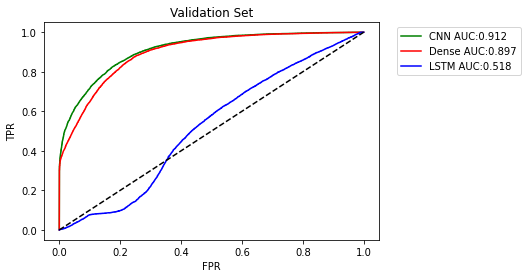

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_test_cnn, tpr_test_cnn, t_test_cnn = roc_curve(y_test, y_test_pred_cnn)
auc_valid_cnn = roc_auc_score(y_test, y_test_pred_cnn)

fpr_test_dense, tpr_test_dense, t_test_dense = roc_curve(y_test, y_test_dense_resul)
auc_valid_dense = roc_auc_score(y_test, y_test_dense_resul)

fpr_test_lstm, tpr_test_lstm, t_test_lstm = roc_curve(y_test, y_test_preds_lstm)
auc_valid_lstm = roc_auc_score(y_test, y_test_preds_lstm)

plt.plot(fpr_test_cnn, tpr_test_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_test_dense, tpr_test_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)
plt.plot(fpr_test_lstm, tpr_test_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()